# Rigid Body Dynamics -- 3D Animation
---
Here we show how to create 3D animations for rigid body dynamics. The motion data must be provided, either ad hoc or from solving the equations of motion (elsewhere).

In [1]:
# set graphics backend
%matplotlib notebook
# import packages
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [2]:
# mesh ellipsoid
ngrid = 20
theta = np.linspace(0, np.pi, ngrid)
phi = np.linspace(0, 2*np.pi, ngrid)
THETA, PHI = np.meshgrid(theta, phi)
a = 3.0
b = 3.0
c = 3.0
X0 = a*np.sin(THETA)*np.cos(PHI)
Y0 = b*np.sin(THETA)*np.sin(PHI)
Z0 = c*np.cos(THETA)
# rotation axis
d = 1.5*c
rotx0 = np.array([[0, 0], [0, 0], [-d, d]])

In [3]:
# time grid
tmin = 0.0
tmax = 1000.0
tsteps = 1001
t = np.linspace(tmin, tmax, tsteps)

In [4]:
# orientation data (ad hoc)
# constant angular frequencies
OMEGA = 2*np.pi/tmax
init_precess  = np.pi/2
omega_precess = 0.25*OMEGA
tilt          = np.pi/9
omega_wobble  = 20*OMEGA
wobble_amp    = np.pi/64
omega_spin    = 8*OMEGA
# euler angles (in radians)
eul_phi   = init_precess*np.ones_like(t) + omega_precess*t
eul_theta = tilt*np.ones_like(t) + wobble_amp*np.cos(omega_wobble*t)
eul_psi   = omega_spin*t

In [5]:
# orientation data (imported from file)
#import h5py
#f = h5py.File('rotation_data.hdf5', mode='r')
#t_data = f['time']
#vel_data = f['angular velocity']
#ang_data = f['euler angles']
#t = t_data[:, 0]
#omega = vel_data[:, 0:3]
#eul_ang = ang_data[:, 0:3]
#f.flush()
#f.close()

# euler angles
#eul_phi = eul_ang[:, 0]
#eul_theta = eul_ang[:, 1]
#eul_psi = eul_ang[:, 2]

In [6]:
# rotation matrix
def rotate(eul_phi, eul_theta, eul_psi):
    c1 = np.cos(eul_phi);   s1 = np.sin(eul_phi)
    c2 = np.cos(eul_theta); s2 = np.sin(eul_theta)
    c3 = np.cos(eul_psi);   s3 = np.sin(eul_psi)
    # NOTE: sign adapted for active transformations
    Rz1 = np.matrix([[c1, -s1, 0], [s1, c1, 0], [0, 0, 1]])
    Rx2 = np.matrix([[1, 0, 0], [0, c2, -s2], [0, s2, c2]])
    Rz3 = np.matrix([[c3, -s3, 0], [s3, c3, 0], [0, 0, 1]])
    return Rz1*Rx2*Rz3

In [7]:
# initialize arrays for ellipsoid orientation
X = np.zeros((ngrid, ngrid, len(t)))
Y = np.zeros((ngrid, ngrid, len(t)))
Z = np.zeros((ngrid, ngrid, len(t)))

# initialize array for axis orientation
rotx = np.zeros((3, 2, len(t)))

In [14]:
# calculate orientation
for i in range(0, tsteps):
    # rotation matrix
    R = rotate(eul_phi[i], eul_theta[i], eul_psi[i])
    # ellipsoid orientation
    X[:, :, i] = R[0,0]*X0 + R[0,1]*Y0 + R[0,2]*Z0
    Y[:, :, i] = R[1,0]*X0 + R[1,1]*Y0 + R[1,2]*Z0
    Z[:, :, i] = R[2,0]*X0 + R[2,1]*Y0 + R[2,2]*Z0
    # axis orientation
    rotx[:, :, i] = np.array(np.dot(R, rotx0))

<IPython.core.display.Javascript object>


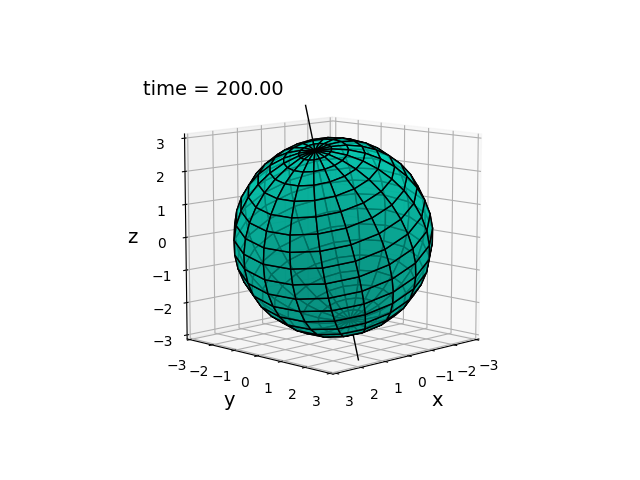

In [9]:
### test plot ###
# frame number
fn=200
# setup figure, axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')
# camera position
ax.view_init(elev=10.0, azim=45.0)
# axis limits
xmax = ymax = zmax = max([a, b, c])
ax.set_xlim3d(-xmax, xmax)
ax.set_ylim3d(-ymax, ymax)
ax.set_zlim3d(-zmax, zmax)
# axis labels
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
# plot elements
ax.plot_surface(X[:, :, fn], Y[:, :, fn], Z[:, :, fn], 
                rstride=1, cstride=1, color='#00FFDF', edgecolor='k', alpha=0.8, linewidth=1)
ax.plot(rotx[0, :, fn], rotx[1, :, fn], rotx[2, :, fn], color = 'k', linewidth=1)
# time text
time_text = ax.text2D(0.0, 0.9, '', transform=ax.transAxes, fontsize=14)
time_template = 'time = %5.2f' 
time = t[fn]
time_text.set_text(time_template % time)
# show
plt.show()

In [11]:
# preliminaries
plt.ioff()   #turn off interactive plotting
surf_plt = None  #create empty plot object
rotx_plt = None  #create empty plot object

# setup figure, axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')
# camera position
ax.view_init(elev=10.0, azim=45.0)
# axis limits
xmax = ymax = zmax = max([a, b, c])
ax.set_xlim3d(-xmax, xmax)
ax.set_ylim3d(-ymax, ymax)
ax.set_zlim3d(-zmax, zmax)
# axis labels
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
# time text
time_text = ax.text2D(0.0, 0.9, '', transform=ax.transAxes, fontsize=14)
time_template = 'time = %5.2f'

# animation function
def update_fig(frame_number, X, Y, Z, rotx):
    global surf_plt, rotx_plt
    # iterator
    fn = frame_number
    # remove previous plot elements
    if surf_plt: surf_plt.remove()
    if rotx_plt: rotx_plt.remove()
    # redraw plot elements
    surf_plt = ax.plot_surface(X[:, :, fn], Y[:, :, fn], Z[:, :, fn], 
                               rstride=1, cstride=1, color='#00FFDF', edgecolor='k', alpha=0.8, linewidth=1)
    rotx_plt, = ax.plot(rotx[0, :, fn], rotx[1, :, fn], rotx[2, :, fn], color = 'k', linewidth=1)
    # update time label
    time = t[fn]
    time_text.set_text(time_template % time)
    
    return surf_plt, rotx_plt, time_text
    
# call animator
anim = animation.FuncAnimation(
    fig, update_fig, frames=np.arange(0,tsteps), fargs=(X, Y, Z, rotx),
    interval=200, repeat_delay=200, repeat=True, blit=True)

plt.close()
plt.ion()

In [395]:
# save animation
file = 'rotation.mp4'
anim.save(file, writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'])

In [1]:
# playback in notebook
from IPython.display import HTML
HTML("""
<video width="800" height="600" controls>
  <source src="rotation.mp4" type="video/mp4">
</video>
""")